In [1]:
import os  
from glob import glob
import numpy as np
from tqdm import trange

import keras_data as D
import utils as U

seed = 0
np.random.seed(seed)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams
from plotting import plot_label
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams.update({
    'image.cmap'     : 'gray',
    'axes.grid'      : False,
    'savefig.dpi'    : 300,  # to adjust notebook inline plot size
    'axes.labelsize' : 14,  # fontsize for x and y labels (was 10)
    'axes.titlesize' : 14,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : False
})

In [2]:
CLASS_NAMES = ["Basement", "SlopeMudA", "Deposit", "SlopeMudB", "SlopeValley", "Canyon"]
num_classes = len(CLASS_NAMES)
dataset = "/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32"
num_sections = 1
patch_shape = tuple([int(s) for s in dataset.split("/")[-1].split("_")[:2]])
batch_size = 32
plot_size = 2

In [3]:
patch_img_list = sorted(glob(os.path.join(dataset, 'patches_XZ*_img.npy')))[:num_sections]
patch_msk_list = sorted(glob(os.path.join(dataset, 'patches_XZ*_msk.npy')))[:num_sections]

## Array Loader

In [4]:
patch_img = []
patch_msk = []
patch_edg = []

for idx in trange(num_sections, ncols=90, desc="File: "):
    img = np.load(patch_img_list[idx])
    msk = np.load(patch_msk_list[idx])
    edg = D._compute_edges(msk)
    
    patch_img += [img[e] for e in range(img.shape[0])]
    patch_msk += [msk[e] for e in range(msk.shape[0])]
    patch_edg += [edg[e] for e in range(edg.shape[0])]

File: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


In [6]:
patch_img = np.asarray(patch_img)
patch_msk = np.asarray(patch_msk)
patch_edg = np.asarray(patch_edg)

### keras.Sequence

#### Single Array Loader

In [7]:
gen = D.PatchArrayLoader(
    inputs=patch_img,
    targets=patch_msk,
    batch_size=batch_size)

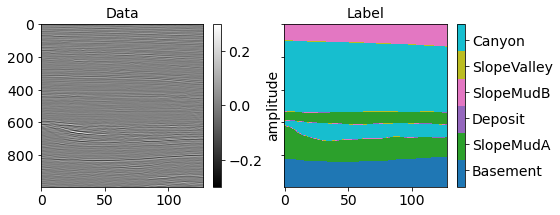

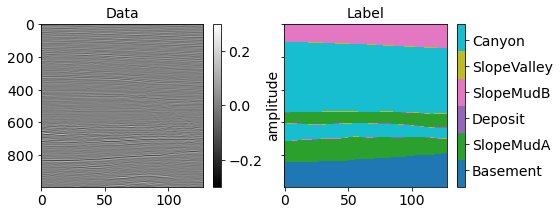

In [8]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
    data=axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    fig.colorbar(data, ax=axs[0],  label='amplitude')
    plot_label(np.argmax(msk[0][i], axis=-1), fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
    axs[1].set_title('Label')
    axs[1].axis('tight')

    plt.show()

#### Single Array Loader with separate classes

In [9]:
gen = D.PatchArrayLoader(
    inputs=patch_img,
    targets=patch_msk,
    batch_size=batch_size,
    separate_class=True)

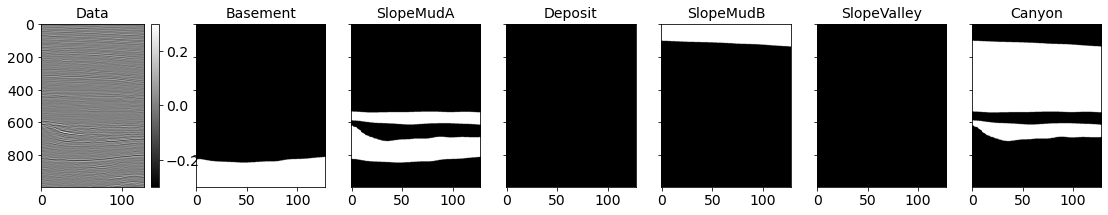

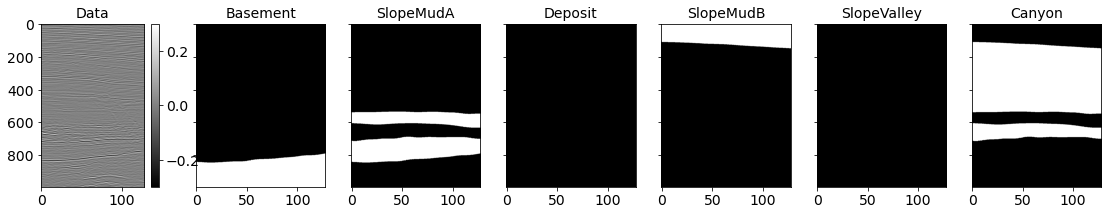

In [10]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 7, sharey=True, figsize=(19, 3))
    data=axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    fig.colorbar(data, ax=axs[0],  label='amplitude')
    
    for l in range(num_classes):
        axs[l+1].imshow(msk[l][i].squeeze(), vmin=0, vmax=1)
        axs[l+1].set_title(CLASS_NAMES[l])
        axs[l+1].axis('tight')

    plt.show()

#### Add also the image itself and the interfaces to the target

In [11]:
gen = D.PatchArrayLoader(
    inputs=patch_img,
    targets=patch_msk,
    batch_size=batch_size,
    separate_class=True,
    use_edges=True,
    use_inputs=True)

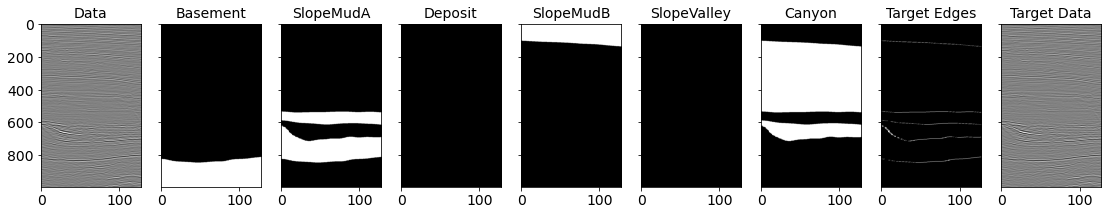

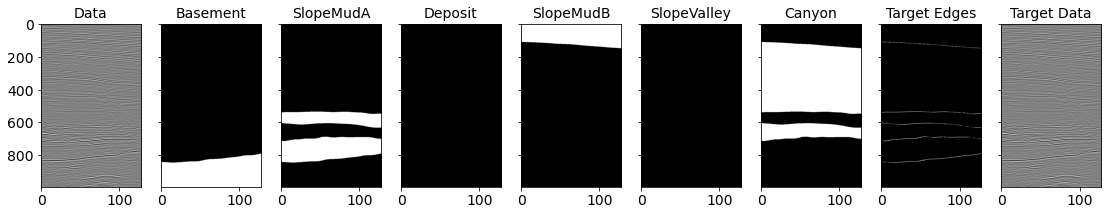

In [12]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 9, sharey=True, figsize=(19, 3))
    axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    
    for l in range(num_classes):
        axs[l+1].imshow(msk[l][i].squeeze(), vmin=0, vmax=1)
        axs[l+1].set_title(CLASS_NAMES[l])
        axs[l+1].axis('tight')
    
    axs[7].imshow(msk[6][i].squeeze())
    axs[7].set_title('Target Edges')
    axs[7].axis('tight')
    
    axs[8].imshow(msk[7][i].squeeze(), clim=(-3e-1,3e-1))
    axs[8].set_title('Target Data')
    axs[8].axis('tight')
    
    plt.show()

### tf.data.Dataset

In [13]:
ds_array = D.PatchArrayDataset(
    input_array=patch_img,
    target_array=patch_msk,
    use_edges=True,
    use_inputs=True, 
    batch_size=batch_size,
    separate_classes=True)

dataset

'/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32'

In [14]:
for b in dataset.take(1):

    fig, axs = plt.subplots(1, 9, sharey=True, figsize=(19, 3))
    
    axs[0].imshow(b[0][0].numpy().squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    
    for l in range(num_classes):
        axs[l+1].imshow(b[l+1][0].numpy().squeeze(), vmin=0, vmax=1)
        axs[l+1].set_title(CLASS_NAMES[l])
        axs[l+1].axis('tight')
    
    axs[7].imshow(b[7][0].numpy().squeeze())
    axs[7].set_title('Target Edges')
    axs[7].axis('tight')
    
    axs[8].imshow(b[8][0].numpy().squeeze(), clim=(-3e-1,3e-1))
    axs[8].set_title('Target Data')
    axs[8].axis('tight')
    
    plt.show()
    

AttributeError: 'str' object has no attribute 'take'

## file loader

### keras.Sequence

All the classes together in one-hot representation; edges and inputs

#### NOTE! This is not working with Model.fit

In [17]:
gen = D.SectionFileLoader(
    inputs=patch_img_list,
    targets=patch_msk_list,
    batch_size=batch_size,
    separate_class=False,
    use_edges=True,
    use_inputs=True)

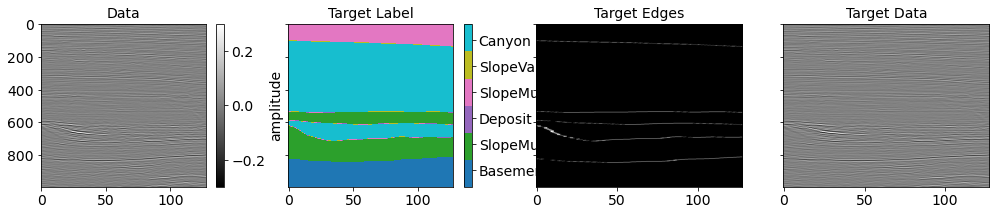

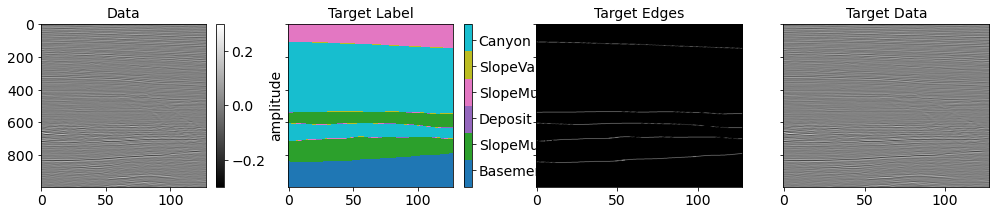

In [18]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
    data=axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    fig.colorbar(data, ax=axs[0],  label='amplitude')
    
    plot_label(np.argmax(msk[0][i], axis=-1), fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
    axs[1].set_title('Target Label')
    axs[1].axis('tight')
    
    axs[2].imshow(msk[1][i].squeeze())
    axs[2].set_title('Target Edges')
    axs[2].axis('tight')
    
    axs[3].imshow(msk[2][i].squeeze(), clim=(-3e-1,3e-1))
    axs[3].set_title('Target Data')
    axs[3].axis('tight')

    plt.show()

### Keras single patch as dict

In [4]:
dict_file_list = sorted(glob(os.path.join(dataset, "singles", "XZ*.npy")))

In [5]:
dict_file_list

['/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p000.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p001.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p002.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p003.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p004.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p005.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p006.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p007.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/normalized_categorical/992_128_2_32/singles/XZ000_p008.npy',
 '/nas/home/fpicetti/datasets/seg_blind_test/n

In [12]:
gen = D.PatchFileLoader(
    inputs=dict_file_list,
    batch_size=batch_size,
    separate_class=False,
    use_edges=True,
    use_inputs=True)

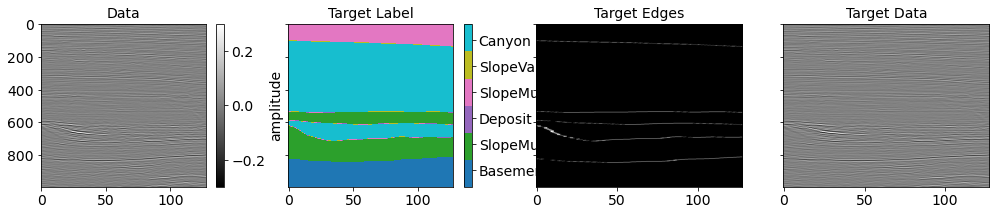

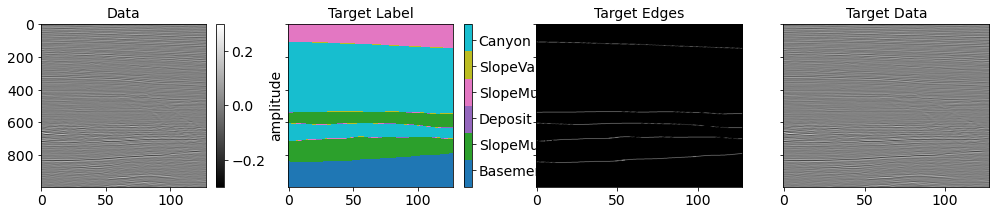

In [13]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 3))
    data=axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    fig.colorbar(data, ax=axs[0],  label='amplitude')
    
    plot_label(np.argmax(msk[0][i], axis=-1), fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
    axs[1].set_title('Target Label')
    axs[1].axis('tight')
    
    axs[2].imshow(msk[1][i].squeeze())
    axs[2].set_title('Target Edges')
    axs[2].axis('tight')
    
    axs[3].imshow(msk[2][i].squeeze(), clim=(-3e-1,3e-1))
    axs[3].set_title('Target Data')
    axs[3].axis('tight')

    plt.show()

In [14]:
gen = D.PatchFileLoader(
    inputs=dict_file_list,
    batch_size=batch_size,
    separate_class=True,
    use_edges=True,
    use_inputs=True)

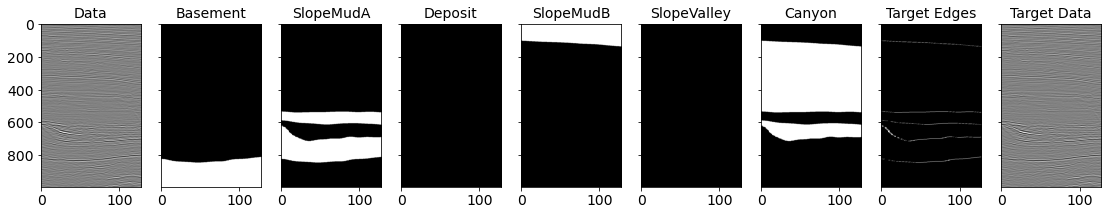

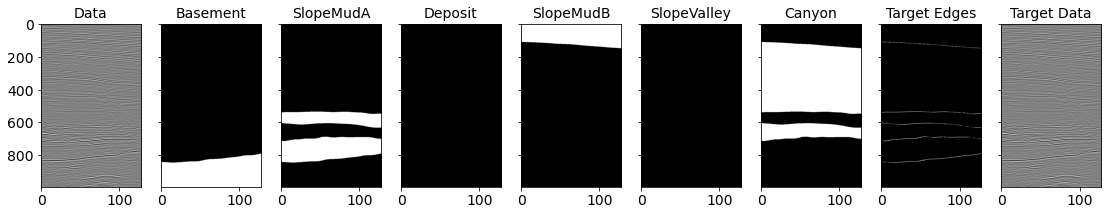

In [15]:
img, msk = gen[0]
for i in range(plot_size):
    fig, axs = plt.subplots(1, 9, sharey=True, figsize=(19, 3))
    axs[0].imshow(img[i].squeeze(), clim=(-3e-1,3e-1))
    axs[0].set_title('Data')
    axs[0].axis('tight')
    
    for l in range(num_classes):
        axs[l+1].imshow(msk[l][i].squeeze(), vmin=0, vmax=1)
        axs[l+1].set_title(CLASS_NAMES[l])
        axs[l+1].axis('tight')
    
    axs[7].imshow(msk[6][i].squeeze())
    axs[7].set_title('Target Edges')
    axs[7].axis('tight')
    
    axs[8].imshow(msk[7][i].squeeze(), clim=(-3e-1,3e-1))
    axs[8].set_title('Target Data')
    axs[8].axis('tight')
    
    plt.show()